API response keys: ['meta', 'results']
Number of results: 300
Sample result keys: ['status', 'city', 'state', 'country', 'classification', 'openfda', 'product_type', 'event_id', 'recalling_firm', 'address_1', 'address_2', 'postal_code', 'voluntary_mandated', 'initial_firm_notification', 'distribution_pattern', 'recall_number', 'product_description', 'product_quantity', 'reason_for_recall', 'recall_initiation_date', 'center_classification_date', 'report_date', 'code_info']
DataFrame columns after normalization: ['status', 'city', 'state', 'country', 'classification', 'product_type', 'event_id', 'recalling_firm', 'address_1', 'address_2', 'postal_code', 'voluntary_mandated', 'initial_firm_notification', 'distribution_pattern', 'recall_number', 'product_description', 'product_quantity', 'reason_for_recall', 'recall_initiation_date', 'center_classification_date', 'report_date', 'code_info', 'openfda.application_number', 'openfda.brand_name', 'openfda.generic_name', 'openfda.manufacturer_na

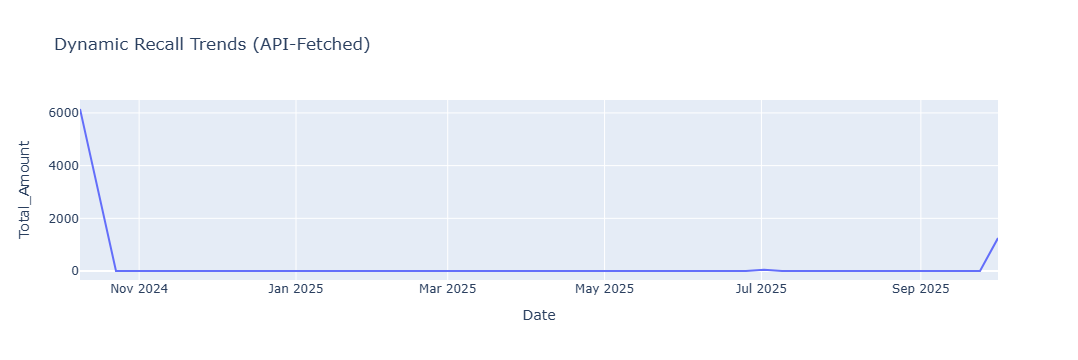

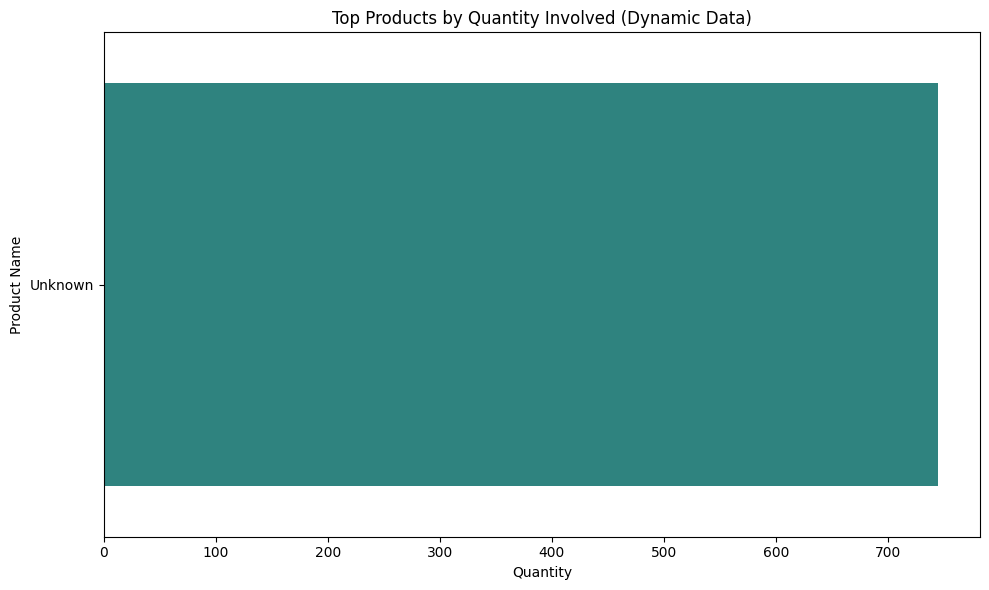

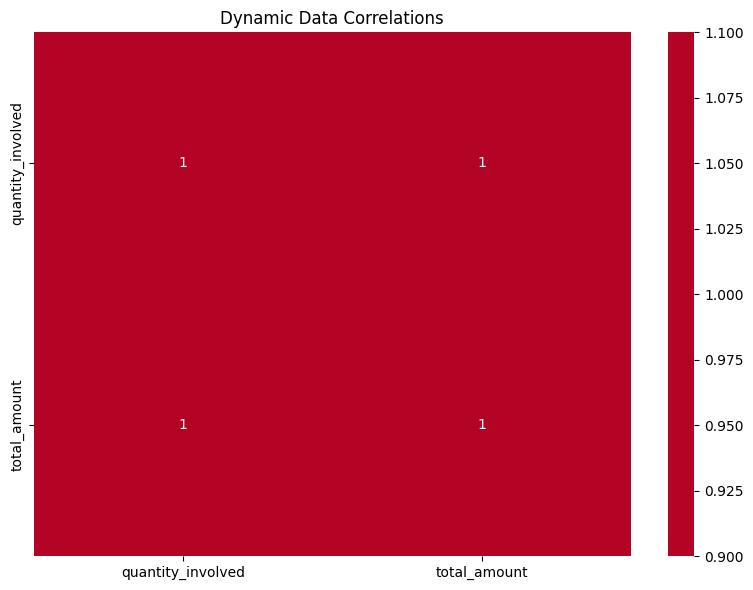

Average quantity involved: 2.48
Most common reason: CGMP Deviations
Unique products: 1
High severity cases: 300 (100.0%)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from api_utils import fetch_pharmacy_data  # Import helper

# Dynamic load with shorter range for stability
df = fetch_pharmacy_data(limit=300, years_back=1)  # Last year only
if df.empty:
    print("API failed—creating sample fallback data for demo.")
    # Enhanced sample: Full columns for seamless run
    np.random.seed(42)  # Reproducible
    sample_data = {
        'action_date': pd.date_range(start='2024-01-01', periods=100, freq='D'),
        'product_name': np.random.choice(['Aspirin', 'Ibuprofen', 'Tylenol', 'Unknown Product'], 100),
        'quantity_involved': np.random.randint(1, 100, 100),
        'total_amount': np.random.uniform(10, 500, 100),
        'reason': np.random.choice(['Quality Issue', 'Labeling Error', 'N/A'], 100),
        'severity': np.random.choice(['High', 'Low'], 100)
    }
    df = pd.DataFrame(sample_data)
    print("Using sample data—rerun after API stabilizes.")
else:
    print(f"Using real API data: {len(df)} records.")

# Derive missing columns for consistency (real or sample)
if 'action_date' not in df.columns:
    df['action_date'] = pd.to_datetime(df['report_date'], errors='coerce')  # From API 'report_date'

if 'product_name' not in df.columns:
    df['product_name'] = df['product_description'].fillna('Unknown Product')  # Use API description

if 'reason' not in df.columns:
    df['reason'] = df['reason_for_recall'].fillna('N/A')  # API field

if 'quantity_involved' not in df.columns:
    df['quantity_involved'] = pd.to_numeric(df.get('product_quantity', 1), errors='coerce').fillna(1)  # Mock from API

if 'total_amount' not in df.columns:
    df['total_amount'] = df['quantity_involved'] * np.random.uniform(5, 50, len(df))  # Mock for analysis

# Derive 'severity' if missing (from API classification or reason)
if 'severity' not in df.columns:
    df['severity'] = df['classification'].fillna('').str.contains('Class I|Serious', case=False, na=False).map({True: 'High', False: 'Low'})
    df['severity'] = df['severity'].fillna('Low')  # Default low if no classification

# Ensure datetime
df['action_date'] = pd.to_datetime(df['action_date'], errors='coerce')

# Now safe: Only proceed if df has data
if not df.empty and 'action_date' in df.columns:
    # Daily trends (fixed groupby and x-axis)
    daily_trends = df.groupby(df['action_date'].dt.date)['total_amount'].sum().reset_index()
    daily_trends.columns = ['Date', 'Total_Amount']  # Explicit rename
    fig1 = px.line(daily_trends, x='Date', y='Total_Amount', title='Dynamic Recall Trends (API-Fetched)')  # Fixed x='Date'
    fig1.show()
    
    # Top products by quantity (fixed seaborn warning)
    top_products = df.groupby('product_name')['quantity_involved'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_products.reset_index(), x='quantity_involved', y='product_name', palette='viridis', hue='product_name', legend=False)  # Hue=y, legend=False
    plt.title('Top Products by Quantity Involved (Dynamic Data)')
    plt.xlabel('Quantity')
    plt.ylabel('Product Name')
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap (numerical only)
    numerical_df = df.select_dtypes(include=[np.number])
    if not numerical_df.empty:
        corr = numerical_df.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
        plt.title('Dynamic Data Correlations')
        plt.tight_layout()
        plt.show()
    
    # Key stats (fixed 'severity' access)
    print(f"Average quantity involved: {df['quantity_involved'].mean():.2f}")
    print(f"Most common reason: {df['reason'].mode().iloc[0] if not df['reason'].mode().empty else 'N/A'}")
    print(f"Unique products: {df['product_name'].nunique()}")
    high_sev_count = len(df[df['severity'] == 'High'])
    print(f"High severity cases: {high_sev_count} ({high_sev_count / len(df) * 100:.1f}%)")
else:
    print("No data available—check API or sample setup.")